In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

#Firstly, load the .json file to a DataFrame
with open('transaction-data-adhoc-analysis.json','r') as f:
    data = pd.read_json(f)

#Function to split multiple transactions by one buyer
def item_split_to_list(transaction_item):
    if ';' in transaction_item:
        item_list = transaction_item.split(';')
        return item_list
    else:
        return [transaction_item]
    
#Function to split the unique items into 'brand | item', and 'qty'
def brand_item(unique_item):
    item_detail_list = unique_item.split(',')
    return (item_detail_list[0]) + ' | ' + item_detail_list[1]
def qty(unique_item):
    item_detail_list = unique_item.split(',')
    return item_detail_list[2]

#Vectorize new function into the 'data' DataFrame (make a new column to preserve the 'transaction_items' col.)
data['transaction_item_list'] = data.apply(lambda x: item_split_to_list(x['transaction_items']), axis=1)

#Use .explode() function to expand the list into rows of the same index (will become a numpy array)
transaction_items_exploded = data['transaction_item_list'].explode()

#Create a new DF to store the numpy array
transaction_items_df = pd.DataFrame()

#Vectorize the 'brand | item' and 'qty' functions
vfunc_brand = np.vectorize(brand_item)
vfunc_qty = np.vectorize(qty)

#Dump the data into the 'transaction_items_df' using the vectorized functions
transaction_items_df['brand | item'] = vfunc_brand(transaction_items_exploded)
transaction_items_df['qty'] = vfunc_qty(transaction_items_exploded)

#Remove unwanted characters in the qty column (only gets the number part)
transaction_items_df['qty'] = transaction_items_df['qty'].str.replace(r'[^0-9]', '',regex=True)

#Convert 'qty' column into integers
transaction_items_df["qty"] = transaction_items_df["qty"].astype(str).astype(int)

#Create a new DataFrame to store unique store items w/o quantity getting in the way
inventory_df = pd.DataFrame(transaction_items_df['brand | item'].unique(), columns=['brand | item'])

#Function that adds the transaction dates per item sold
def transaction_date_per_item(transaction_item_list,transaction_date):
    transaction_dates = []
    for element in transaction_item_list:
        transaction_dates.append(transaction_date)
    return transaction_dates

data['transaction_date_list'] = data.apply(lambda x:transaction_date_per_item(x['transaction_item_list'],x['transaction_date']),axis=1)

#Add the exploded 'transaction_date_list' to the transaction_items_df
transaction_dates_exploded = data['transaction_date_list'].explode(ignore_index=True)
transaction_items_df['transaction_date'] = transaction_dates_exploded

#Split the transaction_date to get the month value easier
transaction_items_df[['year', 'month', 'date']] = transaction_items_df['transaction_date'].str.split('/', expand=True)

#Convert 'year', 'month', and 'date' columns into int
transaction_items_df["year"] = transaction_items_df["year"].astype(str).astype(int)
transaction_items_df["month"] = transaction_items_df["month"].astype(str).astype(int)
transaction_items_df["date"] = transaction_items_df["date"].astype(str).astype(int)

#Get the unit price for each item
dummy_df = pd.DataFrame()
def filter_single_items(trans_item):
    if ';' not in trans_item and '(x1)' in trans_item:
        return trans_item
dummy_df['brand | item']=data.apply(lambda x:filter_single_items(x['transaction_items']),axis=1)
def filter_unit_price(trans_item, value):
    if ';' not in trans_item and '(x1)' in trans_item:
        return value
dummy_df['unit price']=data.apply(lambda x:filter_unit_price(x['transaction_items'],x['transaction_value']),axis=1)
dummy_df.dropna(inplace=True)
dummy_df = dummy_df.drop_duplicates(keep='first')
dummy_df['brand | item'] = dummy_df.apply(lambda x:brand_item(x['brand | item']),axis=1)

#Using SQL .join method, we are able to join the two columns based on their unique values
inventory_df = pd.merge(inventory_df,dummy_df, how='inner')
inventory_df

#Get the quantity for each item in each month
inventory_list = list(inventory_df['brand | item'])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i in range(len(months)):
    total_qty_monthly_list = []
    for j in range(len(inventory_list)): # Go over each month
        # Gives a count of each item in the product list
        totay_qty_item_month = transaction_items_df.loc[(transaction_items_df['brand | item'] == inventory_list[j]) & (transaction_items_df['month']== i+1), 'qty'].sum()
        total_qty_monthly_list.append(totay_qty_item_month)
    inventory_df[f'{months[i]} Qty']= total_qty_monthly_list

#Find the total sale per month
def total_sale_per_item(qty,unit_price):
    return qty * unit_price

for i in range(len(months)):
  inventory_df[f'{months[i]} Sale']=inventory_df.apply(lambda x:total_sale_per_item(x[f'{months[i]} Qty'],x['unit price']), axis=1)
inventory_df

,brand | item,unit price,Jan Qty,Feb Qty,Mar Qty,Apr Qty,May Qty,Jun Qty,Jul Qty,Aug Qty,...,Mar Sale,Apr Sale,May Sale,Jun Sale,Jul Sale,Aug Sale,Sep Sale,Oct Sale,Nov Sale,Dec Sale
0,Exotic Extras | Beef Chicharon,1299.0,9665,10001,9816,9890,10028,9902,0,0,...,12750984.0,12847110.0,13026372.0,12862698.0,0.0,0.0,0.0,0.0,0.0,0.0
1,HealthyKid 3+ | Nutrional Milk,1990.0,9727,9691,9876,9786,9881,9767,0,0,...,19653240.0,19474140.0,19663190.0,19436330.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Candy City | Orange Beans,199.0,9774,10037,9611,9914,9964,10106,0,0,...,1912589.0,1972886.0,1982836.0,2011094.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HealthyKid 3+ | Gummy Vitamins,1500.0,9681,9980,10145,9842,9948,9980,0,0,...,15217500.0,14763000.0,14922000.0,14970000.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HealthyKid 3+ | Yummy Vegetables,500.0,9959,10256,9896,9861,9735,9722,0,0,...,4948000.0,4930500.0,4867500.0,4861000.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Candy City | Gummy Worms,150.0,9559,9996,9986,10043,9801,9934,0,0,...,1497900.0,1506450.0,1470150.0,1490100.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Exotic Extras | Kimchi and Seaweed,799.0,9676,9949,9967,9921,9773,10104,0,0,...,7963633.0,7926879.0,7808627.0,8073096.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
#Create the table of Quantity of Items Sold Per Month
qty_sold_table = pd.pivot_table(inventory_df, values=['Jan Qty','Feb Qty','Mar Qty','Apr Qty','May Qty','Jun Qty'],index=['brand | item'])
qty_sold_table = qty_sold_table.reindex(['Jan Qty','Feb Qty','Mar Qty','Apr Qty','May Qty','Jun Qty'], axis=1)
qty_sold_table.reset_index(inplace=True)
qty_sold_table['Total Items Sold'] = qty_sold_table.sum(axis=1)
qty_sold_table

/var/folders/pc/dtpg04nn7_n0qtynrm2531r80000gn/T/ipykernel_4210/4125177823.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  qty_sold_table['Total Items Sold'] = qty_sold_table.sum(axis=1)


,brand | item,Jan Qty,Feb Qty,Mar Qty,Apr Qty,May Qty,Jun Qty,Total Items Sold
0,Candy City | Gummy Worms,9559,9996,9986,10043,9801,9934,59319
1,Candy City | Orange Beans,9774,10037,9611,9914,9964,10106,59406
2,Exotic Extras | Beef Chicharon,9665,10001,9816,9890,10028,9902,59302
3,Exotic Extras | Kimchi and Seaweed,9676,9949,9967,9921,9773,10104,59390
4,HealthyKid 3+ | Gummy Vitamins,9681,9980,10145,9842,9948,9980,59576
5,HealthyKid 3+ | Nutrional Milk,9727,9691,9876,9786,9881,9767,58728
6,HealthyKid 3+ | Yummy Vegetables,9959,10256,9896,9861,9735,9722,59429


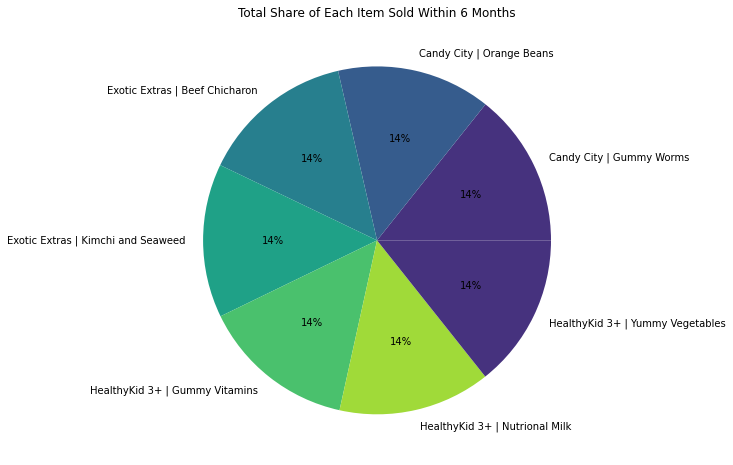

In [3]:
#Create a pie chart that will represent the total share of each item sold
plt.figure(figsize=(10,8))
colors = sns.color_palette('viridis')
plt.title('Total Share of Each Item Sold Within 6 Months')
plt.pie(data=qty_sold_table, x=qty_sold_table['Total Items Sold'], labels = 'brand | item', colors = colors, autopct='%.0f%%')
plt.savefig('pie_qty.png', bbox_inches='tight')

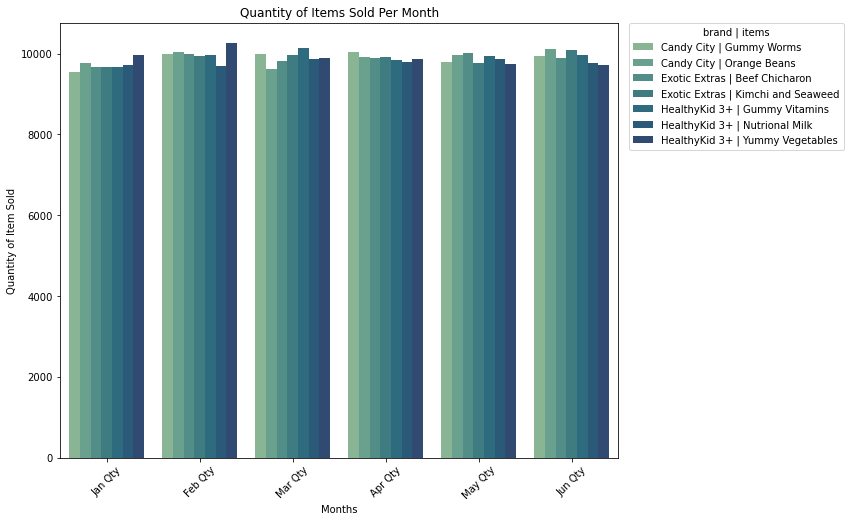

In [4]:
#Create a bar plot to represent the Quantity of Items Sold Per Month

#Drop the 'Total Items Sold' column to not include the data under that column in the 'Quantity of Items Sold Per Month' Bar Plot
qty_sold_table.drop(columns='Total Items Sold',inplace=True)

#Use .melt to plot the bar plot easier
qty_sold_for_plot = qty_sold_table.melt('brand | item',var_name='Months', value_name='Quantity of Item Sold')
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
plt.title('Quantity of Items Sold Per Month')
sns.barplot(x='Months', y='Quantity of Item Sold', hue='brand | item', data=qty_sold_for_plot, palette='crest')
plt.legend(title='brand | items',bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('qty_bar.png', bbox_inches='tight')

In [5]:
#Create the table of Total Sale of Each Item Per Month
total_sales_table = pd.pivot_table(inventory_df, values=['Jan Sale','Feb Sale','Mar Sale','Apr Sale','May Sale','Jun Sale'],index=['brand | item'], sort=False, aggfunc=np.sum, margins=True, margins_name = 'Total Monthly Sales')
total_sales_table = total_sales_table.reindex(['Jan Sale','Feb Sale','Mar Sale','Apr Sale','May Sale','Jun Sale'], axis=1)
total_sales_table['Total Sale Per Item'] = total_sales_table.sum(axis=1)
total_sales_table.reset_index(inplace=True)
#The lower-right corner of the pivot table represents the grand total, and is thus not descriptive of either the 'Total Monthly Sales' row or 'Total Sale Per Item' column
total_sales_table.loc[7,'Total Sale Per Item'] = '---'
total_sales_table

,brand | item,Jan Sale,Feb Sale,Mar Sale,Apr Sale,May Sale,Jun Sale,Total Sale Per Item
0,Exotic Extras | Beef Chicharon,12554835.0,12991299.0,12750984.0,12847110.0,13026372.0,12862698.0,77033298.0
1,HealthyKid 3+ | Nutrional Milk,19356730.0,19285090.0,19653240.0,19474140.0,19663190.0,19436330.0,116868720.0
2,Candy City | Orange Beans,1945026.0,1997363.0,1912589.0,1972886.0,1982836.0,2011094.0,11821794.0
3,HealthyKid 3+ | Gummy Vitamins,14521500.0,14970000.0,15217500.0,14763000.0,14922000.0,14970000.0,89364000.0
4,HealthyKid 3+ | Yummy Vegetables,4979500.0,5128000.0,4948000.0,4930500.0,4867500.0,4861000.0,29714500.0
5,Candy City | Gummy Worms,1433850.0,1499400.0,1497900.0,1506450.0,1470150.0,1490100.0,8897850.0
6,Exotic Extras | Kimchi and Seaweed,7731124.0,7949251.0,7963633.0,7926879.0,7808627.0,8073096.0,47452610.0
7,Total Monthly Sales,62522565.0,63820403.0,63943846.0,63420965.0,63740675.0,63704318.0,---


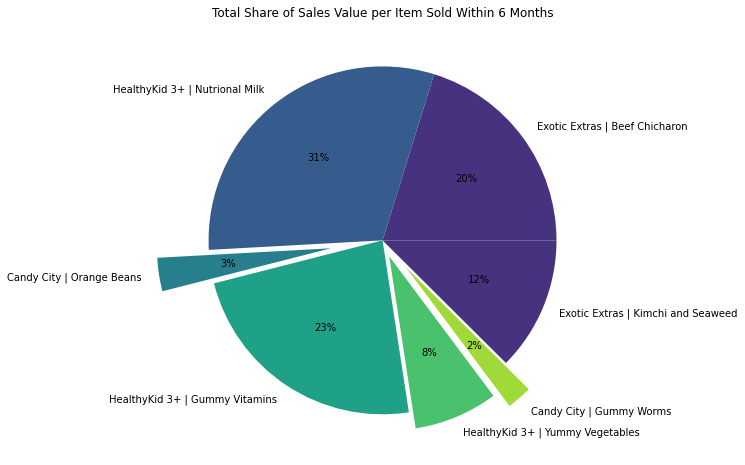

In [6]:
#Create a pie chart that will represent the total share of sales value per item
plt.figure(figsize=(10,8))
colors = sns.color_palette('viridis')
plt.title('Total Share of Sales Value per Item Sold Within 6 Months')
plt.pie(data=total_sales_table, x=total_sales_table.loc[0:6,'Total Sale Per Item'], labels = total_sales_table.loc[0:6,'brand | item'], colors = colors, autopct='%.0f%%', explode=[0,0,0.3,0,0.1,0.2,0])
plt.savefig('pie_sales_item.png', bbox_inches='tight')

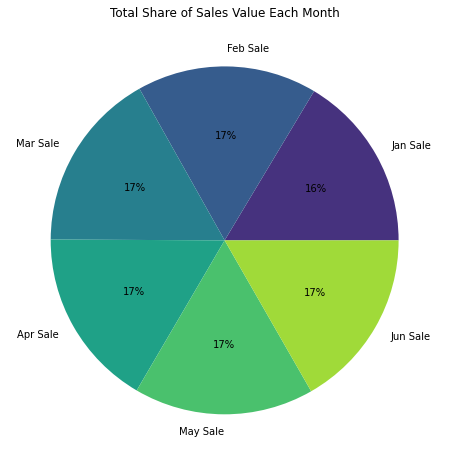

In [7]:
#Create a pie chart that will represent the total share of sales value per month
plt.figure(figsize=(10,8))
colors = sns.color_palette('viridis')
plt.title('Total Share of Sales Value Each Month')
plt.pie(data=total_sales_table, x=total_sales_table.loc[7,['Jan Sale','Feb Sale','Mar Sale','Apr Sale','May Sale','Jun Sale']], labels = ['Jan Sale','Feb Sale','Mar Sale','Apr Sale','May Sale','Jun Sale'], colors = colors, autopct='%.0f%%')
plt.savefig('pie_sales_month.png', bbox_inches='tight')

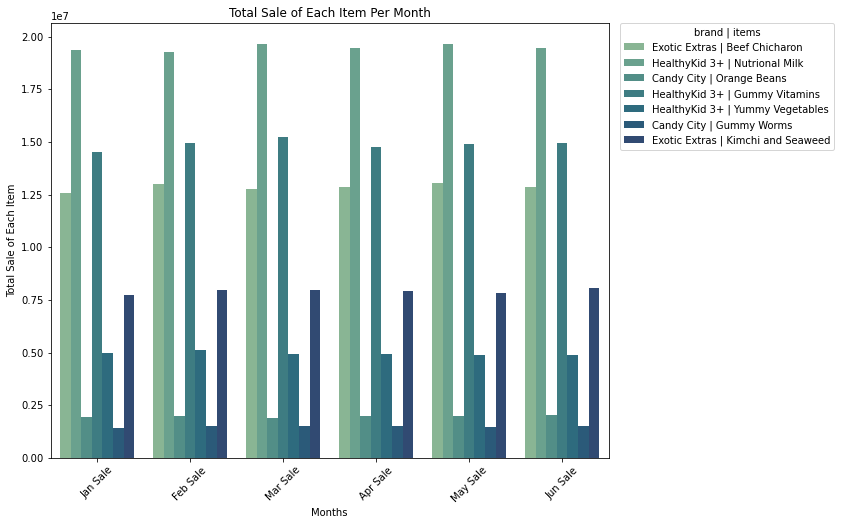

In [8]:
#Create a bar plot to represent the Total Sale of Each Item Per Month

#Drop the 'Total Sale Per Item' column and 'Total Monthly Sales' row to not include the data in the 'Total Sale of Each Item Per Month' Bar Plot
total_sales_table.drop(columns='Total Sale Per Item',inplace=True)
total_sales_table.drop(7,inplace=True,axis=0)

#Use .melt to plot the bar plot easier
total_sales_for_plot = total_sales_table.melt('brand | item',var_name='Months', value_name='Total Sale of Each Item')
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
plt.title('Total Sale of Each Item Per Month')
sns.barplot(x='Months', y='Total Sale of Each Item', hue='brand | item', data=total_sales_for_plot, palette='crest')
plt.legend(title='brand | items',bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('sales_bar.png', bbox_inches='tight')